# Import Our Data

Load the data to your Google Drive. Then you can mount your drive and access the folder wherever you saved it.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Here, we are using the image_dataset_from_directory utilty, which reads images from a file path into a tf.Dataset object. This is much more memory efficient than reading images into lists! The dataset is already organized into training, test, and validation splits on my file system. The labels are inferred from the folder names. 

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = "drive/My Drive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/D/datasets/dogs-vs-cats"
  
train_dataset = image_dataset_from_directory(
    base_dir + "/train/",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir + "/validation/",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir + "/test/",
    image_size=(180, 180),
    batch_size=32)

Found 765 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 798 files belonging to 2 classes.


In [3]:
for data_batch, labels_batch in train_dataset:
     print("data batch shape:", data_batch.shape)
     print("labels batch shape:", labels_batch.shape)
     break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Define Our Model

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers
  
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

We have a binary outcome variable, hence our use of Sigmoid activation on the output layer. We will use binary cross-entropy loss as our loss function. And, we'll monitor accuracy.

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

This callback we are defining will write the current best model (and parameter values) to disk, based on minimum validation loss. 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="drive/My Drive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/D/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

Note that batch size isn't defined here, because we defined it when we first created the tf.Dataset object! This Dataset object is an iterator, containing batches of images.

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
24/24 [==============================] - 88s 2s/step - loss: 0.7296 - accuracy: 0.5242 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/20
24/24 [==============================] - 1s 35ms/step - loss: 0.6923 - accuracy: 0.5242 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 3/20
24/24 [==============================] - 1s 32ms/step - loss: 0.6998 - accuracy: 0.5281 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 4/20
24/24 [==============================] - 1s 35ms/step - loss: 0.7347 - accuracy: 0.5307 - val_loss: 0.6859 - val_accuracy: 0.6100
Epoch 5/20
24/24 [==============================] - 1s 32ms/step - loss: 0.6808 - accuracy: 0.5752 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 6/20
24/24 [==============================] - 1s 33ms/step - loss: 0.6829 - accuracy: 0.5582 - val_loss: 0.6927 - val_accuracy: 0.5225
Epoch 7/20
24/24 [==============================] - 1s 48ms/step - loss: 0.6700 - accuracy: 0.6092 - val_loss: 0.6602 - val_accuracy: 0.6200
Epoch 8/20
24/

And we can plot loss over training iterations...

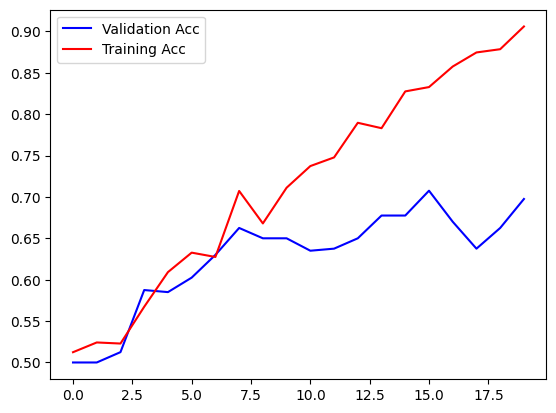

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

Note that we reach > 65% accuracy pretty quickly without much effort, but it plateaus there.

In [ ]:
test_model = keras.models.load_model("drive/My Drive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/D/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc}")

25/25 [==============================] - 34s 882ms/step - loss: 0.6513 - accuracy: 0.6454
Test accuracy: 0.6453633904457092


# Data Augmentation

To stave off the overfitting, we will first start by augmenting our dataset. This is a simple way to do it in a Sequential model, by adding a data augmentation layer. This step in our model will randomly mess with the data at each pass, flipping, rotating and zooming each image. 

In [6]:
data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])

You'll see that adding the aaumentation layer gets us another 5% bump in the validation accuracy of our model, up to about 72% fairly consistently. Note that we do a bit worse than the textbook claims, because we are using less data (I kept about 40% of the sample the book was working with). 

In [7]:
from tensorflow import keras 
from tensorflow.keras import layers
  
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1/255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# We are making a different callback so we don't overwrite our last model (we might want to compare them)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

# And let's fit the model.
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.5320

KeyboardInterrupt: ignored

Let's plot the accuracy over training again... 

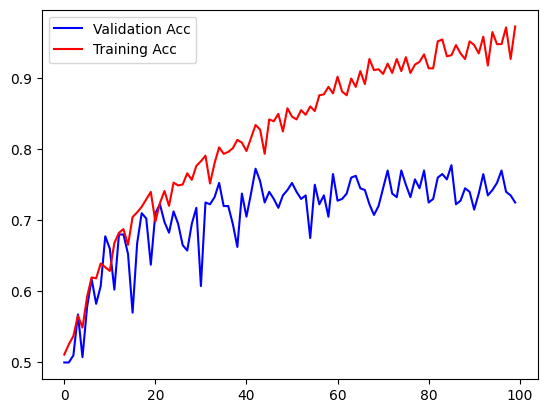

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

And let's check the test accuracy.

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc}")

25/25 [==============================] - 1s 17ms/step - loss: 0.5862 - accuracy: 0.7193
Test accuracy: 0.719298243522644


# Feature Extraction from a Pre-Trained Model: VGG16

Now we are going to load a pre-trained model, to leverage its convolutional base for our task. Note that the convolutional base, alone, is about 15 million parameters.

In [8]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False, # Throw away the densely connected layer at the end.
    input_shape=(180, 180, 3)) # Optional - just for model.summary() call.

conv_base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

Now we run our training, validation, and test data images through the convolutional base, get the feature representations of each according to VGG, and then store them alongside their cat/dog labels.

In [9]:
import numpy as np
  
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
  
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 619ms/step


Here, you can see the dimensionality of the features associated with a single image. The VGG output from the convolutional layer comprises of 512 feature-specific feature maps, that are each 5x5 in dimensionality. 

In [ ]:
print(train_features[0].shape)

(5, 5, 512)


So, now we are going to define a new model that sits on the end of the VGG convolutional layer. It'll take those 512 featuremaps, flatten them, pass them to a Dense layer of 256 nodes, and then feed to a one-node sigmoid output (with some Dropout). This model will fit extremely quickly, and it's accuracy will be way higher, approaching 97%

In [10]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
24/24 [==============================] - 1s 14ms/step - loss: 18.9143 - accuracy: 0.9046 - val_loss: 4.8892 - val_accuracy: 0.9650
Epoch 2/20
24/24 [==============================] - 0s 6ms/step - loss: 2.4489 - accuracy: 0.9752 - val_loss: 14.1804 - val_accuracy: 0.9375
Epoch 3/20
24/24 [==============================] - 0s 6ms/step - loss: 2.6609 - accuracy: 0.9830 - val_loss: 7.6489 - val_accuracy: 0.9550
Epoch 4/20
24/24 [==============================] - 0s 5ms/step - loss: 1.6604 - accuracy: 0.9882 - val_loss: 10.1889 - val_accuracy: 0.9400
Epoch 5/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3892 - accuracy: 0.9922 - val_loss: 12.9427 - val_accuracy: 0.9500
Epoch 6/20
24/24 [==============================] - 0s 5ms/step - loss: 1.0488 - accuracy: 0.9895 - val_loss: 5.5747 - val_accuracy: 0.9450
Epoch 7/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3313 - accuracy: 0.9961 - val_loss: 9.8042 - val_accuracy: 0.9575
Epoch 8/20
24/2

Plotting performance here... 

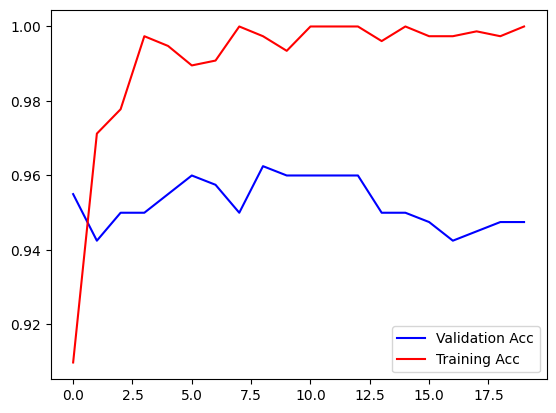

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'],c="b")
plt.plot(history.history['accuracy'],c="r")
plt.legend(['Validation Acc','Training Acc'])
plt.show()

And, evaluating performance on the test data.

In [ ]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels) 
print(f"Test accuracy: {test_acc}")

25/25 [==============================] - 0s 2ms/step - loss: 6.9253 - accuracy: 0.9586
Test accuracy: 0.9586465954780579


# Fine-Tuning from a Pre-Trained Model (with Data-Augmentation)

Here we are going to load the convolutional base, and actually use it inside our network (though we will freeze its parameters so we don't try to update them as we go, since that would ruin the model and add lots of computation time).

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False # The convolutional layers won't be updatable; we just build on them using Functional API.

data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])
  
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                           

And now we can fit our model. This is slower because our forward pass has to go through the VGG convolutional base each iteration (rather than the one time we did when we used it for feature extraction.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset, # Note we are back to working with our original training dataset.
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
24/24 [==============================] - 5s 152ms/step - loss: 26.2179 - accuracy: 0.8680 - val_loss: 4.9792 - val_accuracy: 0.9525
Epoch 2/50
24/24 [==============================] - 4s 152ms/step - loss: 8.7457 - accuracy: 0.9307 - val_loss: 3.8188 - val_accuracy: 0.9600
Epoch 3/50
24/24 [==============================] - 4s 138ms/step - loss: 4.5577 - accuracy: 0.9582 - val_loss: 7.1023 - val_accuracy: 0.9475
Epoch 4/50
24/24 [==============================] - 4s 137ms/step - loss: 4.6958 - accuracy: 0.9569 - val_loss: 6.8383 - val_accuracy: 0.9425
Epoch 5/50
24/24 [==============================] - 4s 140ms/step - loss: 4.3970 - accuracy: 0.9647 - val_loss: 8.7187 - val_accuracy: 0.9425
Epoch 6/50
24/24 [==============================] - 4s 138ms/step - loss: 4.2388 - accuracy: 0.9595 - val_loss: 9.1188 - val_accuracy: 0.9525
Epoch 7/50
24/24 [==============================] - 4s 142ms/step - loss: 2.5272 - accuracy: 0.9752 - val_loss: 12.3043 - val_accuracy: 0.9500
Epoc